### Autoencoder

#### Importe de datos y normalización

In [ ]:
import numpy as np
import tensorflow as tf
import math
import pandas as pd
from matplotlib import pyplot as plt
from urllib import request
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (validation_images, validation_labels) = fashion_mnist.load_data()

In [ ]:
media = np.mean(train_images,axis=0)
desvio = np.std(train_images,axis=0)
train_images = (train_images - media)/desvio
ntr = train_images.shape[0] 
dx = train_images.shape[1]*train_images.shape[2] 
validation_images = (validation_images - media)/desvio

#### Construcción del autoencoder y reporte del error cuadrático

In [ ]:
batchsize = 256
num_epochs = 20
n_hidden_units = 128
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(28,28)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(n_hidden_units, activation='relu',kernel_initializer='GlorotNormal'))
model.add(tf.keras.layers.Dense(dx,kernel_initializer='HeNormal'))
model.add(tf.keras.layers.Reshape((28, 28), input_shape=(dx,)))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 784)               101136    
                                                                 
 reshape_3 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def step_decay(epoch):
   if epoch < 2:
     lrate = 0.01
   else:
     lrate = 0.001 
   return lrate
   
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='MeanSquaredError')
hist = model.fit(x=train_images, y=train_images, batch_size = batchsize, epochs=num_epochs, callbacks = [lrate], validation_data=(validation_images, validation_images))

Epoch 1/20
235/235 [==============================] - 1s 5ms/step - loss: 0.8106 - val_loss: 0.3522 - lr: 0.0100
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2998 - val_loss: 0.2630 - lr: 0.0100
Epoch 3/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2331 - val_loss: 0.2425 - lr: 0.0010
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2199 - val_loss: 0.2336 - lr: 0.0010
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2111 - val_loss: 0.2253 - lr: 0.0010
Epoch 6/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2029 - val_loss: 0.2173 - lr: 0.0010
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1952 - val_loss: 0.2098 - lr: 0.0010
Epoch 8/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1880 - val_loss: 0.2025 - lr: 0.0010
Epoch 9/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1813 - val_loss: 0.1

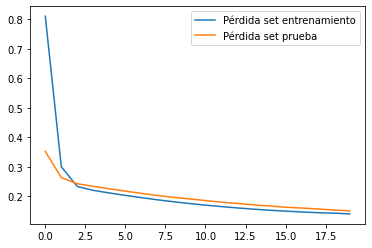

In [ ]:
plt.plot(hist.history["loss"], label="Pérdida set entrenamiento")
plt.plot(hist.history["val_loss"], label="Pérdida set prueba")
plt.legend();

#### Guardado del modelo


In [ ]:
model.save('fashion_mnist_autoencoder.h5')

#### Detector de anomalías

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images_mnist, train_labels_mnist), (validation_images_mnist, validation_labels_mnist) = mnist.load_data()

In [ ]:
validation_images_mnist = (validation_images_mnist - media) / desvio

validation_images_mnist = np.vstack([validation_images_mnist, validation_images])
validation_images_mnist.shape

(20000, 28, 28)

In [ ]:
prediction = model.predict(validation_images_mnist)
prediction = prediction.reshape(20000, 28 * 28)

validation_images_mnist = validation_images_mnist.reshape(20000, 28*28)

ecm = np.sum((validation_images_mnist - prediction)**2 / (validation_images_mnist.shape[1]), axis = 1)

625/625 [==============================] - 1s 2ms/step


In [ ]:
ecm = ecm.reshape((20000, 1))

In [ ]:
def rates(ecm, umbral_start, umbral_stop, umbral_step):
  TPR = []
  FPR = []
  TNR = []
  FNR = []

  mask = np.full((20000), True)
  mask[10000:] = False
  mask = mask.reshape(20000, 1)

  for i in np.arange(umbral_start, umbral_stop, umbral_step):
    TP = np.sum((ecm < i) & (mask == False))
    FP = np.sum((ecm < i) & mask)
    TN = np.sum((ecm >= i) & mask)
    FN = np.sum((ecm >= i) & (mask == False))

    TPR.append(TP / (TP + FN))
    TNR.append(TN / (TN + FP))
    FPR.append(FP / (FP + TN))
    FNR.append(FN / (FN + TP))
    
  return TPR, FPR, TNR, FNR

In [ ]:
TPR, FPR, TNR, FNR = rates(ecm, min(ecm), max(ecm), 0.01)

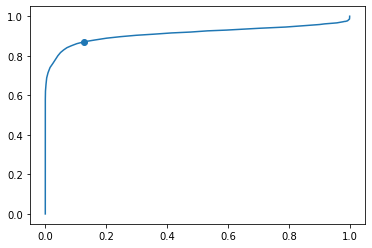

In [ ]:
plt.plot(FPR, TPR)
plt.scatter(FPR[np.argmin(np.absolute((np.array(FNR) - np.array(FPR))))], TPR[np.argmin(np.absolute((np.array(FNR) - np.array(FPR))))])

In [ ]:
EER = FPR[np.argmin(np.absolute((np.array(FNR) - np.array(FPR))))]
EER

0.1285

#### Unidades de menor dimensión

In [66]:
pd.DataFrame(model.layers[1].get_weights()[0]).to_csv("model_weights.csv")